# Orange / Apples Demo

# Data preparation:

In [ ]:
!wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip
!unzip apple2orange.zip
!mkdir -p data && mv apple2orange data/

# Imports:

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torchvision import datasets
import argparse
import numpy as np
import os
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.autograd import Variable
from math import exp

SSIM module
taken from here: https://github.com/Po-Hsun-Su/pytorch-ssim/blob/master/pytorch_ssim/__init__.py
and modified to support the current Pytorch version

In [4]:
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

In [5]:
class OrangeDataset(datasets.VisionDataset):
    """
    Aligned dataset 
  
    Args:
      root (string): Root directory of dataset where ``BulldogDataset/*.pt`` will exist.
      env (string): Which environment to load. Must be 1 of 'train', 'test'\
      transform (callable, optional): A function/transform that  takes in an PIL image
        and returns a transformed version. E.g, ``transforms.RandomCrop``
      target_transform (callable, optional): A function/transform that takes in the
        target and transforms it.
    """

    def __init__(self,
                 root='./data',
                 env='train',
                 size=10000,
                 transform=None,
                 im_size=128):
        super(OrangeDataset, self).__init__(root, transform=transform)

        assert env in ['train', 'test'], "Illegal value for env."
        self.env = env
        self.im_size = im_size
        self.prepare_orange_dataset()
        self.data_label_tuples = torch.load(os.path.join(self.root, 'OrangeDataset', env) + '.pt')

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
    
        Returns:
            tuple: (image, condition) where image is from cam 1, and condition is the cropped bulldog from cam2
        """
        img, label = self.data_label_tuples[index]

        if self.transform is not None:
            img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.data_label_tuples)
    def prepare_orange_dataset(self):
        orange_dataset_dir = os.path.join(self.root, 'OrangeDataset')
        if os.path.exists(os.path.join(orange_dataset_dir, 'train.pt')) \
                and os.path.exists(os.path.join(orange_dataset_dir, 'test.pt')):
            print('Orange dataset dataset already exists')
            return
        print('Preparing Orange dataset')
        images_dir = os.path.join(self.root, 'apple2orange')
        a_dir = os.path.join(images_dir, self.env + 'A')
        b_dir = os.path.join(images_dir, self.env + 'B')
        a_files = [f for f in os.listdir(a_dir)]
        b_files = [f for f in os.listdir(b_dir)]
        data_set = []
        for i in range(len(a_files)):
            filename = a_files[i]
            if i % 1000 == 0:
                print(f'Converting image {i}/{len(a_files)}')
            img = Image.open(os.path.join(a_dir, filename)).resize((self.im_size, self.im_size))
            data_set.append((img, 0))

        for i in range(len(b_files)):
            filename = b_files[i]

            if i % 1000 == 0:
                print(f'Converting image {i}/{len(b_files)}')

            img = Image.open(os.path.join(b_dir, filename)).resize((self.im_size, self.im_size))
            if len(np.array(img).shape) == 3:
                data_set.append((img, 1))
        path = Path(orange_dataset_dir)
        path.mkdir(exist_ok=True)
        torch.save(data_set, os.path.join(orange_dataset_dir, self.env + '.pt'))


def plot_examples(dataset):
    fig = plt.figure(figsize=(13, 8))
    columns = 6
    rows = 2
    # ax enables access to manipulate each of subplots
    ax = []

    for i in range(rows * columns):
        ind = np.random.randint(len(dataset))
        img, label = dataset[ind]
        # create subplot and append to ax
        ax.append(fig.add_subplot(rows, columns, i + 1))
        ax[-1].set_title("label: " + str(label))  # set title
        plt.imshow(img.permute(1, 2, 0))

    plt.show()  # finally, render the plot

# Input arguments  

In [6]:
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument('--im_size',              type=int, default=256, help='image size')
parser.add_argument('--batch_size',           type=int, default=4, help='Batch size (default=12)')
parser.add_argument('--beta_rf',              type=float, default=1e-1, help='real/fake disc loss coefficient')
parser.add_argument('--beta_ind',             type=float, default=1e-1, help='independence disc loss coefficient')
parser.add_argument('--ae_lr',                type=float, default=1e-3, help='learning_rate for ae (default=1e-3)')
parser.add_argument('--d_lr',                 type=float, default=2e-4, help='learning_rate for discriminators optimizers')
parser.add_argument("--min_lr",               type=float, default=1e-5, help="Minimal learning rate")
parser.add_argument("--decay_step_size",      type=int, default=90, help="LR decay step size")
parser.add_argument("--lr_decay_factor",      type=float, default=0.1, help="LR decay factor")
parser.add_argument("--weight_decay",         type=float, default=1e-5, help="l_2 weight penalty")
parser.add_argument("--n_epochs",             type=int, default=200, help="Number of epochs")
parser.add_argument("--train_discs_every",    type=int, default=1, help="Train discriminators every this number of epochs")
parser.add_argument("--train_ae_every",       type=int, default=5, help="Train autoencoder every this number of epochs")
parser.add_argument("--apply_r1_every",       type=int, default=16, help="Apply R1 regularization every this number of epochs")
parser.add_argument("--ind_disc_output_dim",  type=int, default='2', help="Ind discriminator output dimension'")
parser.add_argument("--train_discs_after",    type=int, default=10, help="Start train discriminators after this number of epochs'")

FLAGS = parser.parse_args(args=[])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Datasets

Orange dataset dataset already exists


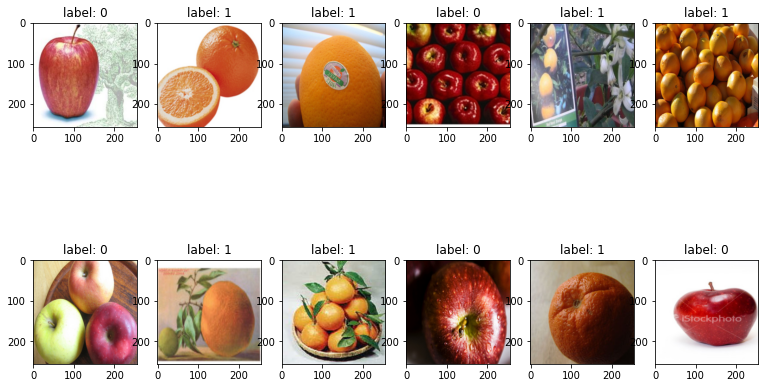

Orange dataset dataset already exists


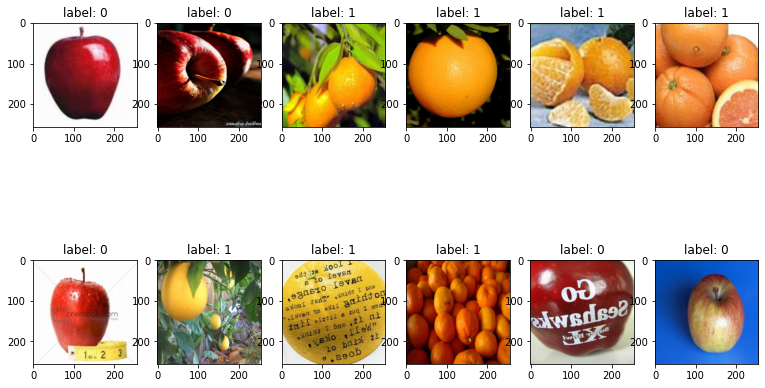

In [7]:
norm_mean = [.5, .5, .5]
norm_std = [.5, .5, .5]

def inverse_normalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor


def plot_examples(dataset):
    fig = plt.figure(figsize=(13, 8))
    columns = 6
    rows = 2
    # ax enables access to manipulate each of subplots
    ax = []
  
    for i in range(rows * columns):
        ind = np.random.randint(len(dataset))  
        img, label = dataset[ind]
        img = inverse_normalize(img, mean=norm_mean, std=norm_std)  
        # create subplot and append to ax
        ax.append(fig.add_subplot(rows, columns, i + 1))
        ax[-1].set_title("label: " + str(label))  # set title
        plt.imshow(img.permute(1, 2, 0))

  
    plt.show()  # finally, render the plot

transform=transforms.Compose([
    transforms.RandomCrop(FLAGS.im_size - 16),          
    transforms.Resize(FLAGS.im_size),                            
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=norm_mean, std=norm_std),
    ])


train_data = OrangeDataset(root='./data', 
                            env='train',
                            im_size=FLAGS.im_size,
                            transform=transform)

plot_examples(train_data) 

test_data = OrangeDataset(root='./data', 
                            env='test',
                            im_size=FLAGS.im_size,
                            transform=transform)

plot_examples(test_data) 

train_kwargs = {'batch_size': FLAGS.batch_size,
                'shuffle': True}
test_kwargs = {'batch_size': FLAGS.batch_size}

train_loader = torch.utils.data.DataLoader(train_data,**train_kwargs)
test_loader = torch.utils.data.DataLoader(test_data, **test_kwargs)

input_dim = 3 * FLAGS.im_size ** 2
n_classes = 2

# Functions for modulation layers


taken from https://github.com/taesungp/swapping-autoencoder-pytorch/

In [8]:
def fused_leaky_relu(input, bias, negative_slope=0.2, scale=2 ** 0.5):
    global use_custom_kernel
    if use_custom_kernel:
        return FusedLeakyReLUFunction.apply(input, bias, negative_slope, scale)
    else:
        dims = [1, -1] + [1] * (input.dim() - 2)
        bias = bias.view(*dims)
        return F.leaky_relu(input + bias, negative_slope) * scale

class EqualLinear(nn.Module):
    def __init__(
        self, in_dim, out_dim, bias=True, bias_init=0, lr_mul=1, activation=None
    ):
        super().__init__()

        self.weight = nn.Parameter(torch.randn(out_dim, in_dim).div_(lr_mul))

        if bias:
            self.bias = nn.Parameter(torch.zeros(out_dim).fill_(bias_init))
        else:
            self.bias = None
        self.activation = activation
        self.scale = (1 / math.sqrt(in_dim)) * lr_mul
        self.lr_mul = lr_mul

    def forward(self, input):
        if self.activation:
            if input.dim() > 2:
                out = F.conv2d(input, self.weight[:, :, None, None] * self.scale)
            else:
                out = F.linear(input, self.weight * self.scale)
            out = fused_leaky_relu(out, self.bias * self.lr_mul)

        else:
            if input.dim() > 2:
                out = F.conv2d(input, self.weight[:, :, None, None] * self.scale, bias=self.bias * self.lr_mul)
            else:
                out = F.linear(input, self.weight * self.scale, bias=self.bias * self.lr_mul)
        return out

    def __repr__(self):
        return (f'{self.__class__.__name__}({self.weight.shape[1]}, {self.weight.shape[0]})')

class GeneratorModulation(torch.nn.Module):
    def __init__(self, styledim, outch):
        super().__init__()
        self.scale = EqualLinear(styledim, outch)
        self.bias = EqualLinear(styledim, outch)

    def forward(self, x, style):
        if style.ndimension() <= 2:
            return x * (1 * self.scale(style)[:, :, None, None]) + self.bias(style)[:, :, None, None]
        else:
            style = F.interpolate(style, size=(x.size(2), x.size(3)), mode='bilinear', align_corners=False)
            return x * (1 * self.scale(style)) + self.bias(style)


# Classes and functios

https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

In [9]:
# Some functions taken from https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block
        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.
        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not
        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out


In [10]:
class Encoder(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, ngf=32, norm_layer=nn.BatchNorm2d, n_downsampling=2, use_dropout=False, 
               n_blocks=2, padding_type='reflect', n_classes=2):
        """Construct a Resnet-based generator
        Parameters:
            input_nc (int)      -- the number of channels in input images
            output_nc (int)     -- the number of channels in output images
            ngf (int)           -- the number of filters in the last conv layer
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            n_blocks (int)      -- the number of ResNet blocks
            padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
        """
        assert(n_blocks >= 0)
        super(Encoder, self).__init__()
        use_bias = norm_layer != nn.BatchNorm2d

        layer1 = [nn.ReflectionPad2d(3),
                  nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                  norm_layer(ngf),
                  nn.ReLU(True)]
        self.layer1 = nn.Sequential(*layer1)

        # downsampling layers
        mult = 2 ** 0
        layer2 = [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                  norm_layer(ngf * mult * 2),
                  nn.ReLU(True)]
        self.layer2 = nn.Sequential(*layer2)

        mult = 2 ** 1
        layer3 = [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                  norm_layer(ngf * mult * 2),
                  nn.ReLU(True)]
        self.layer3 = nn.Sequential(*layer3)
        
        # residual layers
        mult = 2 ** n_downsampling
        layer4 = [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]
        self.layer4 = nn.Sequential(*layer4)
        layer5 = [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]
        self.layer5 = nn.Sequential(*layer5)
        layer6 = [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]
        self.layer6 = nn.Sequential(*layer6)
    
    def forward(self, x):
        """ Standard forward """
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        return x

class Decoder(nn.Module):
    def __init__(self, output_nc=3, ngf=32, norm_layer=nn.InstanceNorm2d, use_dropout=False, n_downsampling=2, 
               n_blocks=2, padding_type='reflect', n_classes=2, label_embedding_dim=512):
        """Construct a Resnet-based generator
        Parameters:
            input_nc (int)      -- the number of channels in input images
            output_nc (int)     -- the number of channels in output images
            ngf (int)           -- the number of filters in the last conv layer
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            n_blocks (int)      -- the number of ResNet blocks
            padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
        """
        assert(n_blocks >= 0)
        super(Decoder, self).__init__()
        use_bias = norm_layer != nn.BatchNorm2d
        self.label_embeddings = nn.Parameter(torch.randn(n_classes, 512))
        self.modulation1 = GeneratorModulation(styledim=label_embedding_dim, outch=ngf * 2 ** 2)
        self.modulation2 = GeneratorModulation(styledim=label_embedding_dim, outch=ngf * 2 ** 2)
        self.modulation3 = GeneratorModulation(styledim=label_embedding_dim, outch=ngf * 2 ** 2)
        self.modulation4 = GeneratorModulation(styledim=label_embedding_dim, outch=ngf * 2 ** 2)
        self.modulation5 = GeneratorModulation(styledim=label_embedding_dim, outch=ngf * 2 ** 1)
        self.modulation6 = GeneratorModulation(styledim=label_embedding_dim, outch=ngf)
        
        # residual layers
        mult = 2 ** n_downsampling
        layer1 = [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]
        self.layer1 = nn.Sequential(*layer1)
        layer2 = [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]
        self.layer2 = nn.Sequential(*layer2)
        layer3 = [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]
        self.layer3 = nn.Sequential(*layer3)

        # upsampling layers
        mult = 2 ** (n_downsampling - 0)
        layer4 = [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                  kernel_size=3, stride=2,
                  padding=1, output_padding=1,
                  bias=use_bias),
                  norm_layer(int(ngf * mult / 2)),
                  nn.ReLU(True)]
        self.layer4 = nn.Sequential(*layer4)

        mult = 2 ** (n_downsampling - 1)
        layer5 = [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                  kernel_size=3, stride=2,
                  padding=1, output_padding=1,
                  bias=use_bias),
                  norm_layer(int(ngf * mult / 2)),
                  nn.ReLU(True)]
        self.layer5 = nn.Sequential(*layer5)
        
        # to RGB layer
        layer6 = [nn.Conv2d(ngf, output_nc, kernel_size=1, padding=0, bias=True),
                 ]
        self.layer6 = nn.Sequential(*layer6)

    def forward(self, x, y):

        style = self.label_embeddings[y]
        x = self.modulation1(x, style)
        x = self.layer1(x)
        x = self.modulation2(x, style)
        x = self.layer2(x)
        x = self.modulation3(x, style)
        x = self.layer3(x)
        x = self.modulation4(x, style)
        x = self.layer4(x)
        x = self.modulation5(x, style)
        x = self.layer5(x)
        x = self.modulation6(x, style)
        x = self.layer6(x)
        return x

class Ind_Discriminator(nn.Module):   
    def __init__(self, 
                 code_dim=1024, 
                 hidden_dim=128, 
                 drop_prob=0.5,
                 norm_layer2=nn.BatchNorm2d,
                 norm_layer=nn.BatchNorm1d,
                 activation=nn.LeakyReLU(),
                 n_classes=2,
                 ndf=32,
                 n_downsampling=2,
                 out_dim=n_classes):
        
        super(Ind_Discriminator, self).__init__()
        self.hidden_dim = hidden_dim
        self.code_dim = code_dim
        self.drop_prob = drop_prob
        self.norm_layer = norm_layer
        self.norm_layer2 = norm_layer2
        self.activation = activation
        self.out_dim = n_classes
        use_bias = norm_layer != nn.BatchNorm2d
        
        # Layers
        self.layer1 = nn.Sequential(
            nn.Conv2d(ndf * (2 ** n_downsampling), 32, 3, padding=1, stride=2, bias=use_bias),
            self.norm_layer2(32),
            self.activation
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 16, 3, padding=1, stride=2, bias=use_bias),
            self.norm_layer2(16),
            self.activation,
            nn.Flatten()
        )

        self.layer3 = nn.Sequential(
            nn.Linear(16 *  int(FLAGS.im_size / 2**4 * FLAGS.im_size / 2**4), 128, bias=use_bias),
            self.norm_layer(128),
            self.activation,
        )

        self.layer4 = nn.Sequential(
            nn.Linear(128, self.out_dim),
        )
        
    def forward(self, x):
        """
        Standard forward on x, model outputs also label embedding
        """
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)        
        return x


class RF_Discriminator(nn.Module):   
    def __init__(self, ndf=32, norm_layer=nn.BatchNorm2d):
        
        super(RF_Discriminator, self).__init__()
        self.label_embeddings = nn.Parameter(torch.randn(n_classes, 1, FLAGS.im_size, FLAGS.im_size))
        use_bias = norm_layer != nn.BatchNorm2d
        self.conv1 = nn.Conv2d(4, ndf, 4, padding=1, stride=2, bias=use_bias)  
        self.conv2 = nn.Conv2d(ndf, ndf * 2 ** 1, 4, padding=1, stride=2, bias=use_bias)
        self.conv3 = nn.Conv2d(ndf * 2 ** 1, ndf * 2 ** 2, 4, padding=1, stride=2, bias=use_bias)
        self.conv4 = nn.Conv2d(ndf * 2 ** 2, ndf * 2 ** 3, 4, padding=1, stride=2, bias=use_bias)
        self.conv5 = nn.Conv2d(ndf * 2 ** 3, ndf * 2 ** 3, 4, padding=1, stride=1, bias=use_bias)
        self.conv6 = nn.Conv2d(ndf * 2 ** 3, 1, 4, padding=0, stride=1)
        self.norm1 = norm_layer(ndf)
        self.norm2 = norm_layer(ndf * 2 ** 1)
        self.norm3 = norm_layer(ndf * 2 ** 2)
        self.norm4 = norm_layer(ndf * 2 ** 3)
        self.norm5 = norm_layer(ndf * 2 ** 3)
        self.activation = nn.LeakyReLU(0.2, True)

        
    def forward(self, x, y):
        """
        Standard forward
        """
        o = self.label_embeddings[y]
        x = torch.cat([x, o], dim=1)
        x = self.activation(self.norm1(self.conv1(x)))
        x = self.activation(self.norm2(self.conv2(x)))
        x = self.activation(self.norm3(self.conv3(x)))
        x = self.activation(self.norm4(self.conv4(x)))
        x = self.activation(self.norm5(self.conv5(x)))
        x = self.conv6(x)
        return x
        
encoder = Encoder()
decoder = Decoder()
ind_discriminator = Ind_Discriminator()
rf_discriminator = RF_Discriminator()
       
encoder.to(device=device)
decoder.to(device=device)
ind_discriminator.to(device=device)
rf_discriminator.to(device=device)


RF_Discriminator(
  (conv1): Conv2d(4, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv5): Conv2d(256, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  (conv6): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
  (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation)

# Loss criterions

In [11]:
l1_criterion = nn.L1Loss()
rf_criterion = nn.BCEWithLogitsLoss()
ind_criterion = nn.CrossEntropyLoss()
ssim_criterion = SSIM()

def ssim_loss(x, y):
    return 1. - ssim_criterion(x, y)

def recon_criterion(x, y, l1_alpha=.9):
    return l1_alpha * l1_criterion(x, y) + (1. - l1_alpha) * ssim_loss(x, y)

def gan_loss (x, should_be_classified_as_real=True):
    if should_be_classified_as_real:
        label = torch.ones(x.shape, dtype=torch.float, device=device)
    else: 
        label = torch.zeros(x.shape, dtype=torch.float, device=device)
    return rf_criterion(x, label)    

def indep_loss(logits, y, should_be_dependent=True):
    if should_be_dependent:
        return ind_criterion(logits, y)  
    else: 
        return -ind_criterion(logits, y)  

def compute_rf_disc_R1_loss(model, x, y):
    x = x.detach().clone()
    x.requires_grad_()
    pred_real = model(x, y).sum()
    grad_real, = torch.autograd.grad(
        outputs=pred_real,
        inputs=[x],
        create_graph=True,
        retain_graph=True,
    )
    grad_real2 = grad_real.pow(2)
    dims = list(range(1, grad_real2.ndim))
    grad_penalty = grad_real2.sum(dims) * 0.5

    return grad_penalty.sum()

# not in use
def compute_ind_disc_R1_loss(model, x):
    x = x.detach().clone()
    x.requires_grad_()
    pred_real = model(x).sum()
    grad_real, = torch.autograd.grad(
        outputs=pred_real,
        inputs=[x],
        create_graph=True,
        retain_graph=True,
    )
    grad_real2 = grad_real.pow(2)
    dims = list(range(1, grad_real2.ndim))
    grad_penalty = grad_real2.sum(dims) * 0.5

    return grad_penalty.sum()  


# Optimizers and Learning rates

In [12]:
def lambda_rule(epoch) -> float:
    """ stepwise learning rate calculator """
    exponent = int(np.floor((epoch + 1) / FLAGS.decay_step_size))
    return np.power(FLAGS.lr_decay_factor, exponent)

def update_lr(optim, scheduler):
        """ Learning rate updater """
        
        scheduler.step()
        lr = optim.param_groups[0]['lr']
        if lr < FLAGS.min_lr:
            optim.param_groups[0]['lr'] = FLAGS.min_lr
            lr = optim.param_groups[0]['lr']
        print('Learning rate = %.7f' % lr) 

ae_optim = torch.optim.Adam(list(encoder.parameters()) +\
                            list(decoder.parameters()),
                            lr=FLAGS.ae_lr, 
                            betas=(0.5, 0.999),
                            weight_decay=FLAGS.weight_decay)

ind_disc_optim = torch.optim.Adam(ind_discriminator.parameters(), 
                                 lr=FLAGS.d_lr, 
                                 betas=(0.5, 0.999),
                                 weight_decay=FLAGS.weight_decay) 

rf_disc_optim = torch.optim.Adam(rf_discriminator.parameters(), 
                                 lr=FLAGS.d_lr, 
                                 betas=(0.5, 0.999),
                                 weight_decay=FLAGS.weight_decay)

ae_sched = lr_scheduler.LambdaLR(ae_optim, 
                                 lr_lambda=lambda_rule) 

ind_disc_sched = lr_scheduler.LambdaLR(ind_disc_optim, 
                                       lr_lambda=lambda_rule)  

rf_disc_sched = lr_scheduler.LambdaLR(rf_disc_optim, 
                                      lr_lambda=lambda_rule)     


# Training and test procedures

In [13]:
def train():
      
    best_val_loss = 1000
    eps = 1e-6
    epoch_counter = 0 
    best_val_indep_gap = 1000
    best_val_recon_loss = 1000

    for epoch in range(FLAGS.n_epochs):
        
        encoder.train(True) 
        decoder.train(True) 
        ind_discriminator.train(True)    
        rf_discriminator.train(True)    
        
        recon_losses = []
        independence_losses = []
        rf_losses = []
        rf_real_losses = []
        rf_recon_losses = []
        rf_swap_losses = []
        

        for step, (batch_x, batch_y) in enumerate(train_loader):
            
            batch_x = batch_x.float().to(device=device)
            batch_y = batch_y.to(device=device)
            
            if ((step % FLAGS.train_discs_every == 0) and (epoch >= FLAGS.train_discs_after)):
                ind_discriminator.zero_grad()
                rf_discriminator.zero_grad()

                code = encoder(batch_x) 
                
                logits = ind_discriminator(code.detach())
                ind_discriminator_loss = indep_loss(logits, batch_y, should_be_dependent=True) 
                    
                code = encoder(batch_x)
                n1 = batch_x.size(0) // 2
                code_for_recon = code[:n1]
                batch_y_for_recon = batch_y[:n1]

                code_for_swap = code[n1:]
                batch_y_for_swap = batch_y[n1:]
                batch_y_for_swap = -batch_y_for_swap + 1

                recon = decoder(code_for_recon, batch_y_for_recon)
                swap = decoder(code_for_swap, batch_y_for_swap)
                
                rf_disc_real_out = rf_discriminator(batch_x, batch_y)
                rf_disc_recon_out = rf_discriminator(recon.detach(), batch_y_for_recon)
                rf_disc_swap_out = rf_discriminator(swap.detach(), batch_y_for_swap)

                recon_loss = recon_criterion(recon, batch_x[:n1])   
                
                rf_loss_real = gan_loss(rf_disc_real_out, should_be_classified_as_real=True)
                rf_loss_fake_r = gan_loss(rf_disc_recon_out, should_be_classified_as_real=False)
                rf_loss_fake_s = gan_loss(rf_disc_swap_out, should_be_classified_as_real=False)
                rf_discriminator_loss = rf_loss_real + .5 * rf_loss_fake_r + .5 * rf_loss_fake_s
                
                rf_real_losses.append(rf_loss_real.item())
                rf_recon_losses.append(rf_loss_fake_r.item())
                rf_swap_losses.append(rf_loss_fake_s.item())

                ind_discriminator_loss.backward()
                rf_discriminator_loss.backward()

                ind_disc_optim.step()
                rf_disc_optim.step()

            if ((step % FLAGS.apply_r1_every) == 0 and (epoch >= FLAGS.train_discs_after)):
                # r1 losses 
                rf_disc_r1_loss = compute_rf_disc_R1_loss(rf_discriminator, batch_x, batch_y)
                rf_disc_r1_loss.backward()
                rf_disc_optim.step()
            
            if step % FLAGS.train_ae_every == 0:
                # train AE
                encoder.zero_grad()
                decoder.zero_grad()
                
                code = encoder(batch_x)
                logits = ind_discriminator(code)
                independence_loss = indep_loss(logits, batch_y, should_be_dependent=False) 
                code = encoder(batch_x)
                n1 = batch_x.size(0) // 2
                code_for_recon = code[:n1]
                batch_y_for_recon = batch_y[:n1]

                code_for_swap = code[n1:]
                batch_y_for_swap = batch_y[n1:]
                p = np.random.permutation(batch_y_for_swap.size(0))
                batch_y_for_swap = -batch_y_for_swap + 1

                recon = decoder(code_for_recon, batch_y_for_recon)
                swap = decoder(code_for_swap, batch_y_for_swap)
                
                rf_disc_recon_out = rf_discriminator(recon, batch_y_for_recon)
                rf_disc_swap_out = rf_discriminator(swap, batch_y_for_swap)
                
                recon_loss = recon_criterion(recon, batch_x[:n1])   
                   
                rf_loss_fake_r = gan_loss(rf_disc_recon_out, should_be_classified_as_real=True)
                rf_loss_fake_s = gan_loss(rf_disc_swap_out, should_be_classified_as_real=True)
                rf_loss =  rf_loss_fake_r + rf_loss_fake_s
                
                if epoch >= FLAGS.train_discs_after:               
                    ae_loss = recon_loss + FLAGS.beta_ind * independence_loss + FLAGS.beta_rf * rf_loss
                else:
                    ae_loss = recon_loss
                ae_loss.backward()
                ae_optim.step()
                
                recon_losses.append(recon_loss.item())
                independence_losses.append(independence_loss.item())
                rf_losses.append(rf_loss.item())
                
                
                if step % 10 == 0:
                    print('Epoch: {}/{}, Step: {}'.format(epoch + 1, 
                                                          FLAGS.n_epochs,
                                                          step))
                    print('AE losses: Recon_loss: {:.3f}, indep loss:  {:.3f}, rf loss: {:.3f}'.format(np.mean(recon_losses),
                                                                                                       np.mean(independence_losses),
                                                                                                       np.mean(rf_losses)))
                    
                    if epoch >= FLAGS.train_discs_after:
                        print('RF disc losses: rf loss real: {:.3f}, rf loss recon:  {:.3f}, rf loss swap: {:.3f}'.format(np.mean(rf_real_losses),
                                                                                                                          np.mean(rf_recon_losses),
                                                                                                                          np.mean(rf_swap_losses)))

                    print('Learning rate = %.7f' % ae_optim.param_groups[0]['lr']) 
                          
    print('Finished training ')
    
def test():    
    
    print('Running test')
    
    encoder.train(False) 
    decoder.train(False) 
    ind_discriminator.train(False)    
    rf_discriminator.train(False) 
    
    test_recon_losses = []
    test_indep_losses = []
    test_rf_losses = []

    
    for (batch_x, batch_y) in test_loader:
        batch_x = batch_x.float().to(device=device)
        batch_y = batch_y.to(device=device)
              
        code = encoder(batch_x)
        logits = ind_discriminator(code)
        independence_loss = indep_loss(logits, batch_y, should_be_dependent=False) 
        
        code = encoder(batch_x)
        n1 = batch_x.size(0) // 2
        code_for_recon = code[:n1]
        batch_y_for_recon = batch_y[:n1]

        code_for_swap = code[n1:]
        batch_y_for_swap = batch_y[n1:]
        p = np.random.permutation(batch_y_for_swap.size(0))
        batch_y_for_swap = -batch_y_for_swap + 1

        recon = decoder(code_for_recon, batch_y_for_recon)
        swap = decoder(code_for_swap, batch_y_for_swap)
        
        rf_disc_recon_out = rf_discriminator(recon, batch_y_for_recon)
        rf_disc_swap_out = rf_discriminator(swap, batch_y_for_swap)

        recon_loss = recon_criterion(recon, batch_x[:n1])   
                 
        rf_loss_fake_r = gan_loss(rf_disc_recon_out, should_be_classified_as_real=True)
        rf_loss_fake_s = gan_loss(rf_disc_swap_out, should_be_classified_as_real=True)
        rf_loss = rf_loss_fake_r + rf_loss_fake_s
            
        test_recon_losses.append(recon_loss.item())
        test_indep_losses.append(independence_loss.item())
        test_rf_losses.append(rf_loss.item())
         
    test_recon_loss = np.mean(test_recon_losses)
    test_indep_loss = np.mean(test_indep_losses)
    test_rf_loss = np.mean(test_rf_losses)
        
    test_loss = test_recon_loss + test_indep_loss + test_rf_loss
       
    print('Test results: ')
    print('Recon_loss: {:.3f}, indep loss:  {:.3f}, rf loss:  {:.3f}'.format(test_recon_loss,
                                                                             test_indep_loss,
                                                                             test_rf_loss))



# Data Analysis

In [14]:
def analyze_data():
    
    encoder.train(False) 
    decoder.train(False) 
    ind_discriminator.train(False) 
    rf_discriminator.train(False)
    
    batch_x = []
    batch_y = []

    inds = np.random.choice(range(len(test_data)), 10)
    for ind in inds:
        batch_x.append(test_data[ind][0])
        batch_y.append(test_data[ind][1])

    batch_x = torch.stack(batch_x, 0) 
    batch_x = batch_x.float().to(device=device)
    batch_y = torch.tensor(batch_y).to(device=device)

    code = encoder(batch_x)
    recon = decoder(code, batch_y)

    # Modification of label 
    fig = plt.figure(figsize=(8, 13))
    columns = 3
    rows = 5
    # ax enables access to manipulate each of subplots
    ax = []
    for i in range(rows):
        ax.append(fig.add_subplot(rows, columns, columns * i + 1))
        if i == 0:
            ax[-1].set_title("org img")  # set title
        ax[-1].get_xaxis().set_visible(False)
        ax[-1].get_yaxis().set_visible(False)
        img = inverse_normalize(batch_x[i].cpu(), mean=norm_mean, std=norm_std)    
        plt.imshow(img.permute(1, 2, 0))

        ax.append(fig.add_subplot(rows, columns, columns * i + 2))
        if i == 0:
            ax[-1].set_title("recon")  # set title
        ax[-1].get_xaxis().set_visible(False)
        ax[-1].get_yaxis().set_visible(False)
        img = inverse_normalize(recon[i].cpu().detach(), mean=norm_mean, std=norm_std)    
        plt.imshow(img.permute(1, 2, 0))
        # 
        code1 = code[i]
        new_label = torch.tensor(1. - batch_y[i]).long().to(device=device)                     
        new_recon = decoder(torch.unsqueeze(code1, 0), torch.unsqueeze(new_label, 0))
        ax.append(fig.add_subplot(rows, columns, columns * i + 3))
        if i == 0:
            ax[-1].set_title("synth")  # set title
        ax[-1].get_xaxis().set_visible(False)
        ax[-1].get_yaxis().set_visible(False)
        img = inverse_normalize(new_recon[0].cpu().detach(), mean=norm_mean, std=norm_std)    
        plt.imshow(img.permute(1, 2, 0))
    
    plt.show()

In [ ]:
train()

In [ ]:
test()
analyze_data()
analyze_data()
analyze_data()
analyze_data()
analyze_data()

See the results in https://github.com/DiSILV/notebooks/blob/main/orange_apples_results.ipynb notebook